# Principal Component Analysis

In [6]:
# import packages
import pandas as pd 
import numpy as np 

In [7]:
# get lemmatized data: 
df = pd.read_csv("data/final_df.csv")

In [8]:
df.head()

,Unnamed: 0,screen_name,user_id,tweet_id,created_at,full_text,favorite_count,retweet_count,in_reply_to_screen_name,hashtags,user_mentions,url,image_url,name,party,legislative_period,lemma_text,stemmed_text,lemma_text_sub,stemmed_text_sub
0,0,AlanTudgeMP,185932331,1.388275e+18,2021-04-30,Get the fundamentals right and lift our game. ...,18.0,7.0,NaN,[],[],https://www.theaustralian.com.au/inquirer/get-...,NaN,Alan Tudge,Liberal Party of Australia,46,get fundamental right lift game see thought pr...,get fundament right lift game see thought prio...,"['lift', 'game', 'priority', 'curriculum', 're...","['game', 'nation', 'curriculum', 'review']"
1,1,AlanTudgeMP,185932331,1.388274e+18,2021-04-30,RT @australian: State and federal education mi...,0.0,6.0,NaN,[],['australian'],NaN,NaN,Alan Tudge,Liberal Party of Australia,46,state federal education minister set oppose el...,state feder educ minist set oppos element prop...,"['state', 'education', 'minister', 'element', ...","['state', 'feder', 'minist', 'element', 'schoo..."
2,2,AlanTudgeMP,185932331,1.388039e+18,2021-04-30,Great support for our $53m Higher Education su...,12.0,3.0,NaN,[],[],https://twitter.com/ITECAust/status/1387941814...,NaN,Alan Tudge,Liberal Party of Australia,46,great support high education support package,great support higher educ support packag,"['support', 'education', 'support', 'package']","['support', 'support', 'packag']"
3,3,AlanTudgeMP,185932331,1.388035e+18,2021-04-30,RT @IndependentHEA: IHEA welcomes today’s anno...,0.0,2.0,NaN,[],"['IndependentHEA', 'AlanTudgeMP', 'stuartrober...",NaN,NaN,Alan Tudge,Liberal Party of Australia,46,ihea welcome todays announcement unveil suite ...,ihea welcom today announc unveil suit budget m...,"['welcome', 'announcement', 'suite', 'budget',...","['ihea', 'welcom', 'today', 'suit', 'budget', ..."
4,4,AlanTudgeMP,185932331,1.388031e+18,2021-04-30,RT @ITECAust: The Australian — As @TimDoddEDU ...,0.0,1.0,NaN,[],"['ITECAust', 'TimDoddEDU']",NaN,NaN,Alan Tudge,Liberal Party of Australia,46,australian report iteca welcome australian gov...,australian report iteca welcom australian gove...,"['report', 'government', 'support', '…']","['report', 'iteca', 'welcom', 'support', 'prov..."


## Identify local word associations

In [9]:
### Identify whether each word appear in each tweet or not
# The column proc_text holds the preprocessed tweet
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
vectorizer = CountVectorizer(ngram_range=(1,1)) # Instantiante the counting class
doc2type = vectorizer.fit_transform(final_df.lemma_text_sub) # Count the number of times each word type appear in each tweet
doc2type[doc2type>0] = 1 # Restrict count to 1, i.e. we get the tweet-frequency of each word (how many tweets it appear in) 
type_names = np.array(vectorizer.get_feature_names()) # Get the sequence of words according to how they are counted
n_docs, n_types = doc2type.shape

In [10]:
# Example of counting #doesnt work
print(df.lemma_text_sub[2])
for word in df.lemma_text_sub[2].split(' ')+['olie']:
    print('{}: {}'.format(word, doc2type[2, vectorizer.vocabulary_[word]]))


['support', 'education', 'support', 'package']


KeyError: "['support',"

### Identify (in)frequent words

In [11]:

# Determine absolute threshold
abs_th = 5

# Calculate the tweet-frequency of each word
type_doc_freq = np.squeeze(np.asarray(np.sum(doc2type, axis=0)/n_docs))

# Identify indices of words that meet the threshold - returns boolean (True/False) array of length = number of words
type_mask = type_doc_freq >= abs_th/n_docs

# Identify the indices of words that meet the threshold
type_mask_idx = np.arange(n_types)[type_mask]

# Print number and share of words that meet criteria
print('{} words ({:0.0f}%) appear in at least {} tweets'.format(sum(type_mask), 100*sum(type_mask)/n_types, abs_th))


10482 words (24%) appear in at least 5 tweets


### Calculate association between words


In [12]:
import scipy.sparse as sp

# Calculate the binarized type co-occurence matrix
type_cooc = doc2type.T @ doc2type

# Calculate the co-occurence tweet-frequency
cooc_doc_freq = type_cooc / n_docs # Does not sum to one, as one terms occurence in a tweet does not exclude others

# Divide observed co-occurence frequency with product of marginal word frequencies (expected co-occurence if 'independent')
# and scale with actual frequency, to give less weight to infrequent co-occurences
type_cooc_assoc = cooc_doc_freq.multiply(sp.csr_matrix(cooc_doc_freq / (sp.csr_matrix(type_doc_freq).T @ sp.csr_matrix(type_doc_freq))))

# Drop self-association
type_cooc_assoc = type_cooc_assoc - sp.dia_matrix((type_cooc_assoc.diagonal()[np.newaxis, :], [0]), shape=type_cooc_assoc.shape)


### Restrict to local neighborhood


In [13]:

# Define key terms
key_type = ['fire']

# Identify all words that include the key terms as substrings (e.g.'corona' is in 'coronakrise')
extended_key_type = np.array([trm for trm in vectorizer.get_feature_names() if any(s_trm in trm for s_trm in key_type)])
print(extended_key_type)

# Identify indices of extended key terms
ktype_idx = np.array([vectorizer.vocabulary_.get(ktype) for ktype in extended_key_type])

# Identify word associations around the extended key terms
ktype_assoc = type_cooc_assoc[ktype_idx,:]

# Get weight the extended key words according to how often they appear
extended_key_type_occurence = np.sum(doc2type[:,ktype_idx], axis=0)
extended_key_type_weight = extended_key_type_occurence / np.sum(extended_key_type_occurence)

# Weight the associations and squeeze to one-dimensional array
weighted_ktype_assoc = extended_key_type_weight @ ktype_assoc
weighted_ktype_assoc = np.squeeze(np.asarray(weighted_ktype_assoc))

# Find the sequence of indices that sort the words associated with the extended key types
sidx = np.argsort(weighted_ktype_assoc)

# Remove infrequent words and the extended key types from sorted index
sidx = np.array([idx for idx in sidx if (idx in type_mask_idx) and (idx not in ktype_idx)])

# Determine size of local neighborhood; can't be greater than number of words with non-zero association
n_ktype_assoc = min(400, sum(weighted_ktype_assoc[sidx]>0))
print(n_ktype_assoc)

# Select nearest (highest) associations
assoc_idx =  sidx[-n_ktype_assoc:]

# Get local association matrix
assoc_matr = type_cooc_assoc[assoc_idx,:][:,assoc_idx]

# Print most associated words
print(type_names[assoc_idx])


['actbushfire' 'australianbushfiredisaster' 'backfire' 'binfire' 'bonfire'
 'bushfire' 'bushfireaustralia' 'bushfireclimate' 'bushfirecommunity'
 'bushfirecrisis' 'bushfirecrisisaustralia' 'bushfireemergency'
 'bushfireforestryhorticulture' 'bushfirepreparation' 'bushfirerecovery'
 'bushfireresiliance' 'bushfiresaustralia' 'bushfiresbut'
 'bushfirescobargo' 'bushfiresin' 'bushfiresnsw' 'bushfirewatch'
 'ceasefire' 'crossfire' 'declaredbushfire' 'dumpsterfire' 'fire'
 'firearm' 'fireball' 'firebird' 'firebirdsqld' 'firebreak' 'firecrisis'
 'firedup' 'fireeye' 'firef' 'firefall' 'firefighte' 'firefighter'
 'firefighting' 'fireground' 'firehouse' 'fireman' 'fireprone' 'fireside'
 'firesplease' 'firetech' 'firework' 'firey' 'forrestdalefire' 'gigagfire'
 'grassfire' 'gunfire' 'hellfire' 'hellfirepass' 'hoursfire'
 'ifireaalycaredilldgivemyrealname' 'megafire' 'misfire' 'notredamefire'
 'nowbushfirelexton' 'nswbushfire' 'opbushfireassist'
 'operationbushfireassist' 'pantsonfire' 'qldfire' '

# creating actor term matrix

## Count the number of times each actor use each word

In [14]:
sidx = np.argsort(np.array(df.party)) # list of indices that would sort by party, which is the column of the party
actor_names, grp_start_idx = np.unique(np.array(df.party)[sidx], return_index=True) # Identify unique actor names and where actor name changes in sorted list
actor2type = np.add.reduceat(doc2type[sidx,:].toarray(), grp_start_idx) # Sum word count for all tweets by each actor
n_actors = actor2type.shape[0]

### Scale the count data


In [15]:
# Many options, e.g. measure of association as between words (PPMI)
# Here, we just calculate frequency, and scale frequencies for each word

# Calculate how frequent each actor use each word
actor2type_frequency = actor2type/actor2type.sum(axis=1)[:, np.newaxis]

# Scale frequency within each associated word (zero mean, unit variance)
from sklearn.preprocessing import StandardScaler
standardized_actor2type_frequency = StandardScaler().fit_transform(actor2type_frequency[:, assoc_idx])

# See the raw counts
pd.DataFrame(actor2type[:,assoc_idx], index = actor_names, columns = type_names[assoc_idx])

# See the standardized word frequencies
pd.DataFrame(standardized_actor2type_frequency, index = actor_names, columns = type_names[assoc_idx])


,scenario,pls,adelaide,consideration,november,sea,respond,expert,try,commissioner,...,crisis,phantom,chief,volunteer,area,brigade,recovery,bush,emergency,season
Australian Greens,1.440497,-0.146980,-0.470031,1.871727,0.288593,-0.556699,-1.024234,0.986984,2.421332,-0.331480,...,2.486670,-0.377964,1.984118,-1.248239,-1.260513,0.564859,1.107405,-0.575771,2.533756,-0.545509
Australian Labor Party,-0.224210,-0.605156,-0.371270,1.028002,-0.283249,-0.520886,0.106632,0.978411,0.352805,-0.421861,...,0.152630,2.645751,0.032886,0.683517,-0.869828,-0.361998,-0.268883,-0.467795,-0.342649,-0.117494
Centre Alliance,-0.750970,2.347019,2.623698,-0.978093,-1.412689,-1.112030,-0.408809,-1.061132,-0.303527,0.039835,...,-0.652351,-0.377964,0.774442,-0.425605,-0.510794,-1.059012,-1.077497,-1.110722,-0.047944,-0.163843
Independent,-0.750970,0.795692,-0.104167,-0.978093,1.454055,1.695249,1.639735,-1.061132,-0.299651,2.478560,...,-0.560087,-0.377964,-1.286888,0.091667,0.240237,-1.059012,-1.077497,1.593533,-0.800641,-2.011399
Katter's Australian Party,-0.750970,-0.764084,-0.560252,-0.978093,-1.412689,-1.112030,-1.428925,-1.061132,0.156485,-1.174580,...,0.253765,-0.377964,-1.286888,-1.451788,0.218404,-1.059012,-1.077497,-1.110722,-0.800641,1.653175
Liberal National Party of Queensland,-0.750970,-0.504257,-0.408303,0.221803,0.497476,-0.020880,1.297349,0.663556,-0.777181,-0.363195,...,-0.422650,-0.377964,-0.253963,-0.251950,2.231904,0.992145,1.726120,0.916411,-0.004386,0.920311
Liberal Party of Australia,-0.111471,-0.523979,-0.270645,0.407933,-0.309453,0.202398,0.322805,1.301077,-0.757768,0.008696,...,-0.529908,-0.377964,0.224440,0.963740,-0.415579,0.204633,0.244898,-0.434264,-0.398846,0.109608
The Nationals,1.899065,-0.598254,-0.439029,-0.595187,1.177956,1.424877,-0.504554,-0.746632,-0.792495,-0.235975,...,-0.728069,-0.377964,-0.188147,1.638658,0.366169,1.777398,0.422952,1.189330,-0.138650,0.155149


# Perform and assess PCA


In [18]:

#Multiple options - here, I show:
#Singular Value Decomposition (SVD) - what we did in the paper
#Scikit-learn PCA implementation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
#For rotations, consider the factor_analyzer module, which allow for rotations: https://pypi.org/project/factor-analyzer/

## Option 1. Perform Singular Value Decomposition (SVD) - what we did in the paper
U, s, VT = np.linalg.svd(standardized_actor2type_frequency, full_matrices=False) #Perform SVD on standardized frequencies
S = np.diag(s) # s is array of singular values, convert to diagonal matrix

# Obtain (standardized) principal component scores - not directly comparable to sklearn, that yields U@S
# Given we re-scale in next step, scaling U by sqrt(n-1) does not make a difference
PC = U*np.sqrt(n_actors-1) # Columns of PC are the standardized scores

# Standardize by maximum absolute value on each dimension
scaled_PC = PC / np.max(abs(PC), axis=0)

# Obtain standardized term loadings (maps from PC to feature space)
L = VT.T@S/np.sqrt(n_actors-1) # Only unique up to a factor, so sign (direction) may change compared to other implementations

# Obtain word weights (maps from feature to PC space)
W = (VT.T@np.linalg.inv(S))*np.sqrt(n_actors-1)

# Get eigenvalues of correlation matrix
eigen_values = np.diag(S@S)/(S.shape[0]-1)

# Calculate proportion of captured variance
explained_variance = eigen_values / np.sum(eigen_values)


In [19]:

## Option 2. Use the PCA implementation in Scikit-Learn:
from sklearn.decomposition import PCA

# Instantiate the PCA class
pca = PCA(n_components=n_actors)

# Return unstandardized PC scores (i.e. U@S from SVD)
raw_PC = pca.fit_transform(standardized_actor2type_frequency)

# Get singular values
S = np.diag(pca.singular_values_)

# Get standardized PC scores
PC = raw_PC@np.linalg.inv(S)*np.sqrt(n_actors-1)

# Scale PC scores
scaled_PC = PC / np.max(abs(PC), axis=0)

# Obtain standardized term loadings (maps from PC to feature space)
L = pca.components_.T@S/np.sqrt(n_actors-1)

# Obtain word weights (maps from feature to PC space)
W = (pca.components_.T@np.linalg.inv(S))*np.sqrt(n_actors-1) # Get word weights (maps from feature to PC space)

# Get proportion of captured variance
explained_variance = pca.explained_variance_ratio_


### Example of relations between original data and PC scores


In [20]:

## From original data to PC scores
# The inner product (sumproduct) of the third NGOs standardized word frequencies and the word loadings on the second PC
print(sum(standardized_actor2type_frequency[2,:]*W[:,1]))
# The second PC score of the third NGO
print(PC[2,1])

## From PC scores to original data
# The inner product (sumproduct) of the third NGOs PC scores and the loadings of the fourth word
print(sum(PC[2,:]*L[3,:]))
# The fourth standardized word frequency of the third NGO
print(standardized_actor2type_frequency[2,3])

### Inspect loadings
# For unit-scaled features, they are the correlation between the standardized PCs and the features
# I.e. how much does each words standardized frequency correlate with each PC dimension
print(L.max())
print(L.min())
pd.DataFrame(L, index=type_names[assoc_idx], columns=['PC{}'.format(d) for d in range(1,L.shape[1]+1)])

# Calculate the cumulative amount of variance captured
cumulative_variance = np.cumsum(explained_variance)


-0.49817356602417456
-0.49817356602417584
-0.978092570963724
-0.9780925709637233
1.0255927735443735
-0.9135396159951767


### Assess the amount of variance captured by each principal components

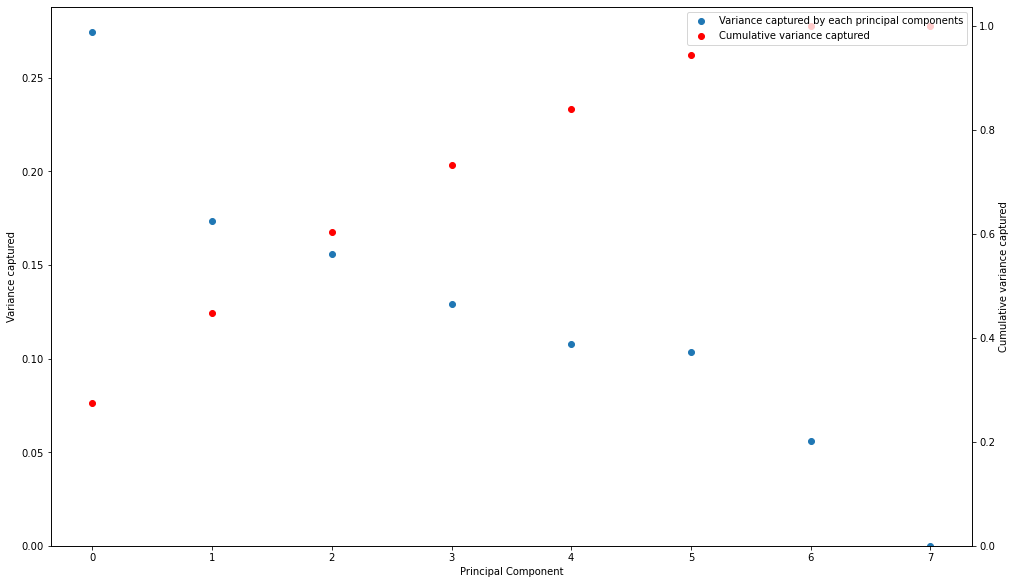

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize = (14,8), constrained_layout=True)

# Plot the amount of variance captured by each principal components
sc1 = ax.scatter(range(n_actors), explained_variance, label='Variance captured by each principal components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance captured')
ax.set_ylim(ymin=0)

# Plot the cumulative amount of variance captured on second y-axis
ax2 = ax.twinx()  # Create second y-axis
sc2 = ax2.scatter(range(n_actors), cumulative_variance, color='red', label='Cumulative variance captured')
ax2.set_ylabel('Cumulative variance captured')
ax2.set_ylim(ymin=0)

plt.legend(handles = [sc1, sc2], loc=1)
plt.show()


### Identify the types that loads most on each principal dimension


In [22]:

# Determine how many words to plot in each direction
n_terms = 15

# Identify the indices that sorts the two first components
PCa_load_sidx = L[:,0].argsort()
PCb_load_sidx = L[:,1].argsort()

# Find the terms that load most on the first principal component
PCa_plot_idx = np.concatenate((PCa_load_sidx[:n_terms], PCa_load_sidx[-n_terms:]))

# Identify remaining indices
remain_idx = np.array([idx for idx in PCb_load_sidx if idx not in PCa_plot_idx])

# Find the remaining terms that load most on the second principal component
PCb_plot_idx = np.concatenate((remain_idx[:n_terms], remain_idx[-n_terms:]))

# Combine the indices
PC_plot_idx = np.unique(np.concatenate((PCa_plot_idx, PCb_plot_idx)))

# Get the term names
PC_plot_names = type_names[assoc_idx][PC_plot_idx]

# Get the term loadings
PC_plot_load = L[PC_plot_idx,:]


### Plot the socio-symbolic constellation


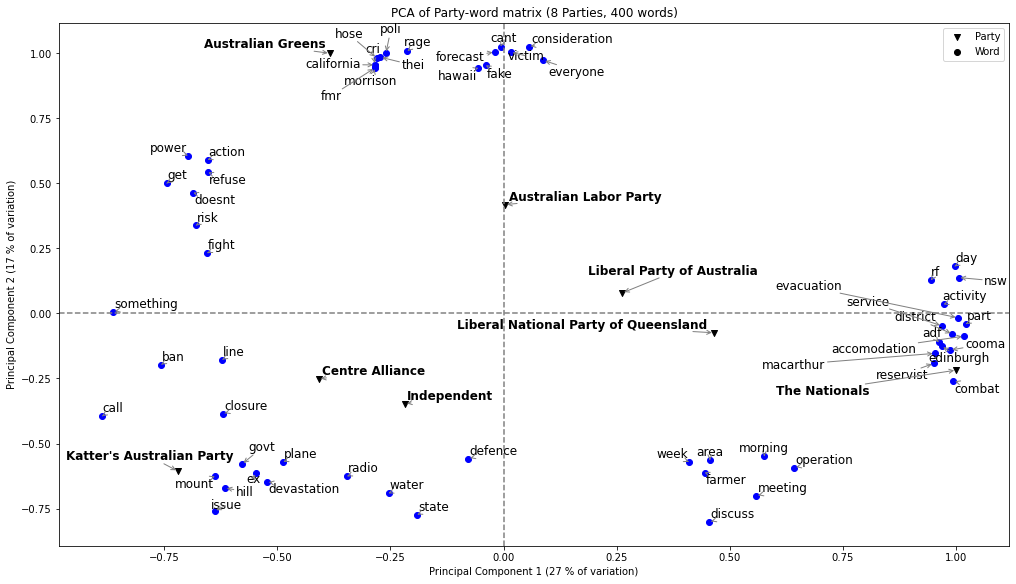

In [24]:
import os
os.system('pip install adjustText')


from adjustText import adjust_text

fig, ax = plt.subplots(1, 1, figsize=(14, 8), constrained_layout=True)

# Title and label text
ax.set_title('PCA of Party-word matrix ({} Parties, {} words)'.format(standardized_actor2type_frequency.shape[0],
                                                                 standardized_actor2type_frequency.shape[1],
                                                                 fontsize=20, fontweight='bold'))
ax.set_xlabel(
    'Principal Component 1 ({:0.0f} % of variation)'.format(100 * pca.explained_variance_ratio_[0], fontsize=15))
ax.set_ylabel(
    'Principal Component 2 ({:0.0f} % of variation)'.format(100 * pca.explained_variance_ratio_[1], fontsize=15))

# Grid to mark zero loading
ax.axvline(x=0, c='grey', linestyle='--')
ax.axhline(y=0, c='grey', linestyle='--')

# Plot standardized principal component scores
ax.scatter(scaled_PC[:, 0], scaled_PC[:, 1], marker='v', label='Party', c='black')

# Plot word loadings
ax.scatter(PC_plot_load[:, 0], PC_plot_load[:, 1], marker='o', label='Word', c='blue')

# Annotate the plot
texts = []
for x, y, txt in zip(scaled_PC[:, 0], scaled_PC[:, 1], actor_names):
    texts.append(plt.text(x, y, txt, size=12, weight='bold'))

for x, y, txt in zip(PC_plot_load[:, 0], PC_plot_load[:, 1], PC_plot_names):
    texts.append(plt.text(x, y, txt, size=12))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey'))  # This part is slow

# Set legend to black
plt.legend()
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')

plt.show()



In [25]:

# pca and dimensionality reduction
# Select words
words = ['fire', 'climate']

# Get their indices
count_widx = [vectorizer.vocabulary_[w] for w in words]
# sth wrong in the following
# origiinal: standardized_widx = [np.where(type_names[assoc_idx]==w)[0][0] for w in words]
standardized_widx = [np.where(type_names[assoc_idx]==w)[0][0] for w in words]

### Plot count and frequency
fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)

ax.set_xlabel(words[0])
ax.set_ylabel(words[1])
ax.scatter(actor2type[:, count_widx[0]], actor2type[:, count_widx[1]],
           alpha=0.5, label='Count', color='blue')
ax.scatter(standardized_actor2type_frequency[:, standardized_widx[0]],
           standardized_actor2type_frequency[:, standardized_widx[1]],
           alpha=0.5, label='Standardized frequency', color='black')

texts = []

for x, y, txt in zip(actor2type[:, count_widx[0]], actor2type[:, count_widx[1]], actor_names):
    if (x != 0) and (y != 0):
        texts.append(plt.text(x, y, txt, size=12, weight='bold'))
for x, y, txt in zip(standardized_actor2type_frequency[:, standardized_widx[0]],
                     standardized_actor2type_frequency[:, standardized_widx[1]],
                     actor_names):
    if (x > 0) and (y > 0):
        texts.append(plt.text(x, y, txt, size=12))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey'))  # This part is slow
plt.legend()
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0